# 导入包

In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False

#使用pandas读取数据支持xls和xlsx
dataB=pd.read_excel(r"./data/bankload.xlsx")
dataB.head(2)

,ID,age,age_group,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,1,41,3,3,17,12,35.9,11.90,0.504108,3.767992,0
1,2,30,2,1,13,8,46.7,17.88,1.352694,6.997266,0


# 因变量描述

In [41]:
dataB['default'].value_counts()

0    3744
1    1256
Name: default, dtype: int64

# 清除部分y=0的数据

In [170]:
dataB['rand'] = np.random.randint(0,100,5000)
dataB['y']=np.where((dataB['default']==0) & (dataB['rand']<35),0,                                #35是控制y=0的比例35%
                                                                np.where(dataB['default']==1,1,-1))#注意：这里是-1表示未标记数据
dataB['y'].value_counts()

-1    2430
 0    1314
 1    1256
Name: y, dtype: int64

# 构建半监督模型
## x与y分组

In [171]:
SemiY=dataB['y']
SemiX=dataB.iloc[:,[2,3,4,5,6,7,8,9]]

## svm与自定义分类器

In [172]:
from sklearn.semi_supervised import SelfTrainingClassifier    #自定义分类器
from sklearn.svm import SVC                                   #支持向量机

baseC = SVC(probability=True,random_state=123)
Straining = SelfTrainingClassifier(baseC, threshold=0.7)
Straining.fit(SemiX, SemiY)

SelfTrainingClassifier(base_estimator=SVC(probability=True, random_state=123),
                       threshold=0.7)

## 预测频数

In [173]:
pd.DataFrame(Straining.predict(SemiX)).value_counts()

0    3442
1    1558
dtype: int64

## 评估最终准确性

              precision    recall  f1-score   support

         非违约       0.88      0.81      0.85      3744
          违约       0.55      0.68      0.61      1256

    accuracy                           0.78      5000
   macro avg       0.72      0.75      0.73      5000
weighted avg       0.80      0.78      0.79      5000



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

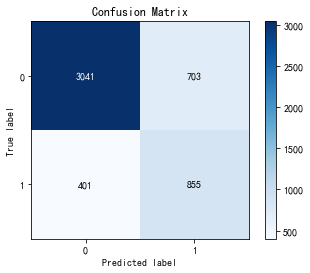

In [174]:
dataB["ypred"]=pd.DataFrame(Straining.predict(SemiX))
dataB
from sklearn.metrics import classification_report
import scikitplot

print(classification_report(dataB["default"],dataB["ypred"],target_names=['非违约','违约']))
scikitplot.metrics.plot_confusion_matrix(dataB["default"],dataB["ypred"])

# svc构建完整数据的准确性

In [175]:
Y=dataB['default']
X=dataB.iloc[:,[2,3,4,5,6,7,8,9]]

svc = SVC(probability=True,random_state=123)
svc.fit(X, Y)
pre=svc.predict(X)
print(classification_report(dataB["default"],pre,target_names=['非违约','违约']))

              precision    recall  f1-score   support

         非违约       0.80      0.97      0.88      3744
          违约       0.76      0.28      0.41      1256

    accuracy                           0.80      5000
   macro avg       0.78      0.62      0.64      5000
weighted avg       0.79      0.80      0.76      5000



# 构建半监督模型：标签蔓延算法
## 超参数说明

In [176]:
from sklearn.semi_supervised import LabelSpreading
labelSM = LabelSpreading()
labelSM.fit(SemiX, SemiY)

LabelSpreading()

In [177]:
print(pd.DataFrame(labelSM.predict(SemiX)).value_counts())
labelPre=pd.DataFrame(labelSM.predict(SemiX))
print(classification_report(dataB["default"],labelPre,target_names=['非违约','违约']))

F:\python\anzhuang\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


0    2985
1    2015
dtype: int64
              precision    recall  f1-score   support

         非违约       1.00      0.80      0.89      3744
          违约       0.62      1.00      0.77      1256

    accuracy                           0.85      5000
   macro avg       0.81      0.90      0.83      5000
weighted avg       0.91      0.85      0.86      5000



F:\python\anzhuang\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


## 网格搜索

In [178]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

#HalvingRandomSearchCV网格搜索:高性能
parameters={'kernel':['knn','rbf'],   #knn效率高，rbf准确
            'n_neighbors':[3,5,7,9],  #3-6是常用的范围
            'gamma':randint(1,100),   #超参数高效搜索
            'alpha':[0.1,0.2,0.5]     #软夹持效应：0.2对应保留原始数据80%的标签不参与修改，否则根据权重修改 
           }
HR_search=HalvingRandomSearchCV(labelSM,parameters,n_jobs=-1)  #scoring='accuracy'
HR_search.fit(SemiX, SemiY)
print("最优得分：%s" %HR_search.best_score_)
# print("测试得分：%s" %HR_search.score(xtest,ytest))
print("全部及最优系数：%s" %HR_search.best_estimator_)

最优得分：0.34938271604938276
全部及最优系数：LabelSpreading(alpha=0.1, gamma=49, kernel='knn', n_neighbors=3)


In [188]:
#最后使用最优系数构建模型
HRmodel=HR_search.best_estimator_
HRypre=HRmodel.fit(SemiX, SemiY)
pd.DataFrame(HRypre.predict(SemiX)).value_counts()

F:\python\anzhuang\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


0    2983
1    2017
dtype: int64